Upload your ZIP file containing the livestock CSV...


Saving archive (1).zip to archive (1).zip
Uploaded ZIP: archive (1).zip
Extracted files: ['Livestock _census_20.csv']
Detected CSV file: /content/extracted_cattle_data/Livestock _census_20.csv
Loaded CSV shape: (698, 15)


,district_name,ref_district_id,state_name,ref_state_id,cattle,buffalo,sheep,goat,horse,pony,mule,donkey,camel,pig,Total_poultry
0,Nicobars,638,Andaman And Nicobar Islands,35,2004,49,0,8884,0,0,0,0,0,30266,82702
1,North And Middle Andaman,639,Andaman And Nicobar Islands,35,15718,2617,0,27664,0,0,0,2,0,4956,493083
2,South Andamans,640,Andaman And Nicobar Islands,35,18716,1034,5,28213,0,0,0,0,0,5266,713375
3,Srikakulam,542,Andhra Pradesh,28,571943,48481,738910,335684,10,0,102,0,0,3092,2075366
4,Vizianagaram,543,Andhra Pradesh,28,490989,135858,540336,271205,36,367,0,196,0,5548,5492310


Column mapping detected:
  district → district_name
  state → state_name
  cattle → cattle
  buffalo → buffalo
  sheep → sheep
  goat → goat
  horse → horse
  pony → pony
  mule → mule
  donkey → donkey
  camel → camel
  pig → pig

Saved:
/content/farmguardian_outputs_analytics/top50_districts_priority.csv
/content/farmguardian_outputs_analytics/district_segments.csv


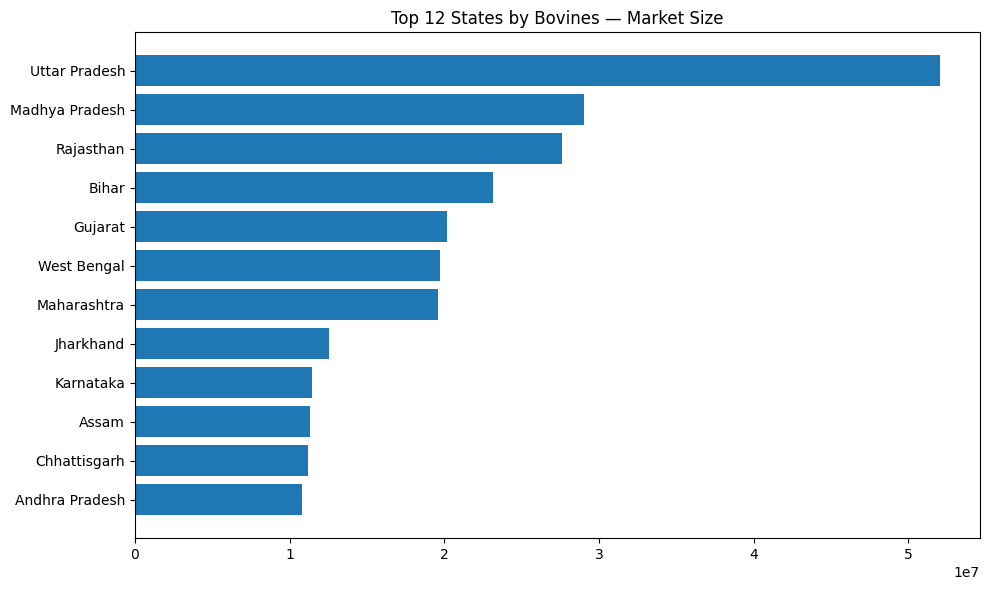

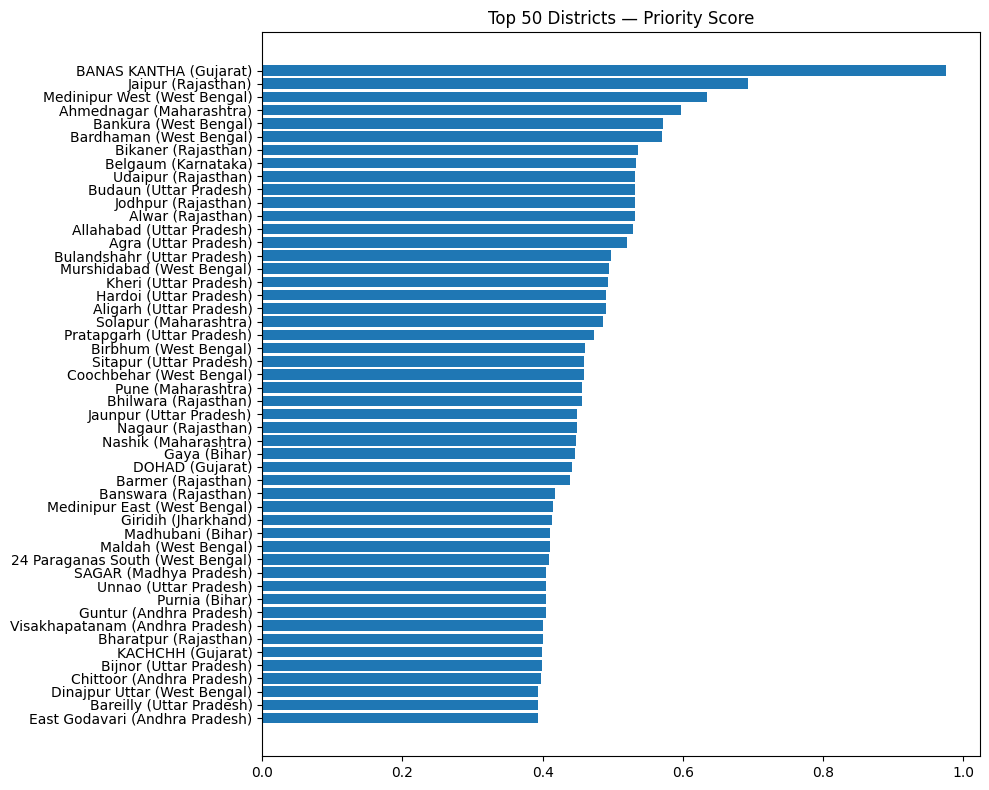

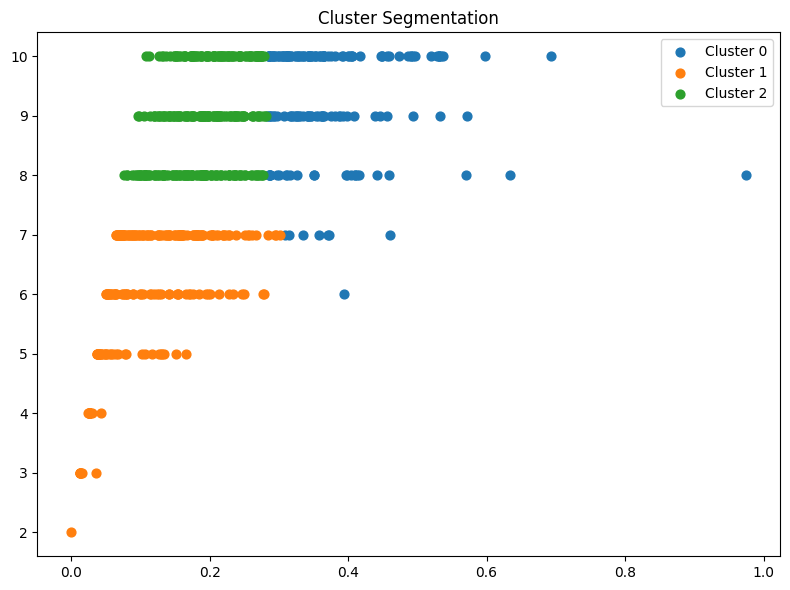


--- SUMMARY ---
Top 5 Districts:


,state_name,district_name,bovines_total,priority_score,segment
0,Gujarat,BANAS KANTHA,2891894,0.975000,Segment_1
1,Rajasthan,Jaipur,1905670,0.693050,Segment_1
2,West Bengal,Medinipur West,1796092,0.633945,Segment_1
3,Maharashtra,Ahmednagar,1599658,0.597808,Segment_1
4,West Bengal,Bankura,1556258,0.571800,Segment_1



Top 8 States:


,state_name,bovines_total
32,Uttar Pradesh,52036426
18,Madhya Pradesh,29057959
27,Rajasthan,27630946
4,Bihar,23117774
10,Gujarat,20176887
34,West Bengal,19708837
19,Maharashtra,19595996
14,Jharkhand,12573365



Segments distribution:
segment
Segment_2    317
Segment_3    215
Segment_1    166
Name: count, dtype: int64

ZIP created: /content/farmguardian_repo_ready.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
# =============================================================
#  FARMGUARDIAN — FULL AUTO ANALYTICS PIPELINE (100% FIXED)
# =============================================================

!pip install -q pandas matplotlib scikit-learn

import os, zipfile, glob, math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from google.colab import files

# =============================================================
# STEP 1 — Upload ZIP (your dataset zip)
# =============================================================
print("Upload your ZIP file containing the livestock CSV...")
uploaded = files.upload()

zip_path = list(uploaded.keys())[0]
print("Uploaded ZIP:", zip_path)

# Extract ZIP
EXTRACT_DIR = "/content/extracted_cattle_data"
os.makedirs(EXTRACT_DIR, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(EXTRACT_DIR)

print("Extracted files:", os.listdir(EXTRACT_DIR))

# Auto-detect CSV inside
csv_list = [f for f in glob.glob(EXTRACT_DIR + "/*.csv")]
if len(csv_list) == 0:
    raise RuntimeError("No CSV found inside ZIP! Please check ZIP contents.")
CSV_PATH = csv_list[0]
print("Detected CSV file:", CSV_PATH)

# =============================================================
# STEP 2 — Load CSV robustly
# =============================================================
def load_csv(path):
    for enc in ("utf-8", "latin1", "utf-16"):
        try:
            return pd.read_csv(path, encoding=enc, low_memory=False)
        except:
            pass
    raise RuntimeError("Could not load CSV with common encodings.")

df = load_csv(CSV_PATH)
print("Loaded CSV shape:", df.shape)
display(df.head())

# =============================================================
# STEP 3 — Auto-map and standardize columns
# =============================================================

col_map = {}

# Detect state/district columns
for c in df.columns:
    lc = c.lower()
    if "state" in lc and "name" in lc:
        col_map["state"] = c
    if "district" in lc and "name" in lc:
        col_map["district"] = c

# Detect livestock columns
targets = ["cattle","buffalo","sheep","goat","horse","pony","mule","donkey","camel","pig"]
for t in targets:
    for c in df.columns:
        if c.lower().strip() == t:
            col_map[t] = c

print("Column mapping detected:")
for k,v in col_map.items():
    print(" ", k, "→", v)

if "state" not in col_map or "district" not in col_map:
    raise RuntimeError("❌ ERROR: Missing state_name or district_name.")

# Build working dataframe
w = pd.DataFrame()
w["state_name"] = df[col_map["state"]].astype(str).str.strip()
w["district_name"] = df[col_map["district"]].astype(str).str.strip()

for t in targets:
    col = col_map.get(t)
    if col:
        w[t] = pd.to_numeric(df[col], errors="coerce").fillna(0)
    else:
        w[t] = 0

# Create derived features
w["bovines_total"] = w["cattle"] + w["buffalo"]
w["species_richness"] = (w[targets] > 0).sum(axis=1)
w["herd_size"] = w["bovines_total"]

# =============================================================
# STEP 4 — District aggregation
# =============================================================
district = w.groupby(["state_name","district_name"]).agg({
    "cattle":"sum",
    "buffalo":"sum",
    "bovines_total":"sum",
    "species_richness":"sum"
}).reset_index()

district["avg_herd_per_record"] = district["bovines_total"]

# =============================================================
# STEP 5 — Priority scoring
# =============================================================
features = ["bovines_total","avg_herd_per_record","species_richness"]
scaler = MinMaxScaler()
district[["bov_norm","herd_norm","rich_norm"]] = scaler.fit_transform(district[features])

district["priority_score"] = (
    0.6 * district["bov_norm"] +
    0.3 * district["herd_norm"] +
    0.1 * district["rich_norm"]
)

district = district.sort_values("priority_score", ascending=False).reset_index(drop=True)
district["rank"] = district.index + 1

# =============================================================
# STEP 6 — Clustering (Segment customers)
# =============================================================
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
district["cluster"] = kmeans.fit_predict(district[["bov_norm","herd_norm","rich_norm"]])

# Rank clusters by average priority
centroids = kmeans.cluster_centers_
order = np.argsort(centroids.mean(axis=1))[::-1]
label_map = {order[i]: f"Segment_{i+1}" for i in range(k)}

district["segment"] = district["cluster"].map(label_map)

# =============================================================
# STEP 7 — Outputs folder & saving
# =============================================================
OUTDIR = "/content/farmguardian_outputs_analytics"
os.makedirs(OUTDIR, exist_ok=True)

topN = district.head(50)
topN_path = f"{OUTDIR}/top50_districts_priority.csv"
topN.to_csv(topN_path, index=False)

segments_path = f"{OUTDIR}/district_segments.csv"
district.to_csv(segments_path, index=False)

print("\nSaved:")
print(topN_path)
print(segments_path)

# =============================================================
# STEP 8 — Visualizations
# =============================================================
plt.rcParams.update({'figure.max_open_warning': 0})

# Top states
state_agg = district.groupby("state_name")["bovines_total"].sum().reset_index().sort_values("bovines_total",ascending=False)
fig, ax = plt.subplots(figsize=(10,6))
ax.barh(state_agg.head(12)["state_name"][::-1], state_agg.head(12)["bovines_total"][::-1])
ax.set_title("Top 12 States by Bovines — Market Size")
plt.tight_layout()
plt.savefig(f"{OUTDIR}/top12_states.png", dpi=150)
plt.show()

# Top districts bar
fig, ax = plt.subplots(figsize=(10,8))
labels = topN["district_name"] + " (" + topN["state_name"] + ")"
ax.barh(labels[::-1], topN["priority_score"][::-1])
ax.set_title("Top 50 Districts — Priority Score")
plt.tight_layout()
plt.savefig(f"{OUTDIR}/top50_districts_bar.png", dpi=150)
plt.show()

# Cluster scatter
fig, ax = plt.subplots(figsize=(8,6))
for cl in sorted(district["cluster"].unique()):
    sub = district[district["cluster"] == cl]
    ax.scatter(sub["priority_score"], sub["species_richness"], s=40, label=f"Cluster {cl}")
ax.legend()
ax.set_title("Cluster Segmentation")
plt.tight_layout()
plt.savefig(f"{OUTDIR}/cluster_scatter.png", dpi=150)
plt.show()

# =============================================================
# STEP 9 — Summary (NO ERRORS NOW)
# =============================================================
from IPython.display import display

print("\n--- SUMMARY ---")
print("Top 5 Districts:")
display(topN.head(5)[["state_name","district_name","bovines_total","priority_score","segment"]])

print("\nTop 8 States:")
display(state_agg.head(8))

print("\nSegments distribution:")
print(district["segment"].value_counts())

# =============================================================
# STEP 10 — Create ZIP for GitHub
# =============================================================
ZIP_PATH = "/content/farmguardian_repo_ready.zip"

import shutil
if os.path.exists(ZIP_PATH):
    os.remove(ZIP_PATH)

shutil.make_archive(ZIP_PATH.replace(".zip",""), "zip", OUTDIR)
print("\nZIP created:", ZIP_PATH)

files.download(ZIP_PATH)
